<a href="https://colab.research.google.com/github/SalhaAlzahrani/ConvAttenMixer/blob/main/VisionTransfomers_MRI_Brain_Tumor_Classification_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔵 Image classification with Vision Transformers

# 🧠 MRI Brain Tumor Classification

# Requirmenets

In [ ]:
!pip install -U tensorflow-addons
!pip install vit-keras
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 27.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras.metrics
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import SGD,Adam

from vit_keras import vit, utils
from google.colab import drive
import tensorflow_addons as tfa


# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)

# Configure the hyperparameters


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
label_smoothing = 0.1

BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 4
input_shape = (224, 224, 3)
NUM_EPOCHS = 30

# Prepare the data

In [ ]:
# train data
train_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Training/',
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    seed=1024,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

# validation data
val_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Testing/',
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    seed=1024,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)



---



# ViT_b16

In [ ]:
vit_model = vit.vit_b16(
    image_size=IMG_SIZE,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=NUM_CLASSES
)

model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(NUM_CLASSES, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_4 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 128)               98432     
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 64)         

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=4, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 214s 1s/step - loss: 0.7500 - accuracy: 0.7969 - precision: 0.8635 - recall: 0.7187 - f1_score: 0.7761 - val_loss: 0.8157 - val_accuracy: 0.7262 - val_precision: 0.7705 - val_recall: 0.6377 - val_f1_score: 0.6338
Epoch 2/30
179/179 [==============================] - 31s 173ms/step - loss: 0.6004 - accuracy: 0.8796 - precision: 0.9018 - recall: 0.8519 - f1_score: 0.8689 - val_loss: 0.7444 - val_accuracy: 0.7948 - val_precision: 0.8206 - val_recall: 0.7674 - val_f1_score: 0.7732
Epoch 3/30
179/179 [==============================] - 31s 173ms/step - loss: 0.5722 - accuracy: 0.8922 - precision: 0.9074 - recall: 0.8699 - f1_score: 0.8827 - val_loss: 0.9405 - val_accuracy: 0.7338 - val_precision: 0.7624 - val_recall: 0.7048 - val_f1_score: 0.6332
Epoch 4/30
179/179 [==============================] - 31s 173ms/step - loss: 0.5491 - accuracy: 0.9007 - precision: 0.9137 - recall: 0.8818 - f1_score: 0.8920 - val_loss: 0.9693 - val_accuracy: 0

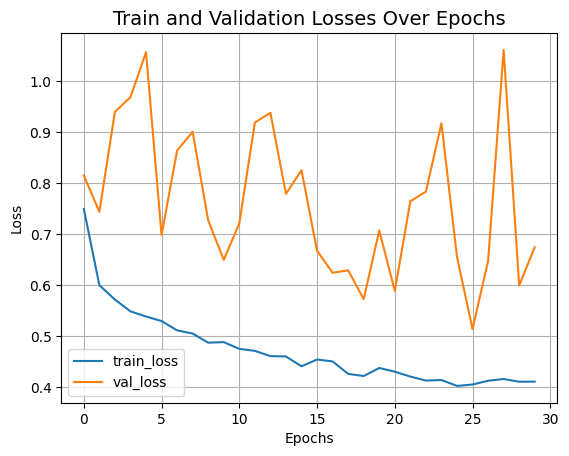

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()



---



# ViT_132

In [ ]:
vit_model = vit.vit_l32(
    image_size=IMG_SIZE,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=NUM_CLASSES
)

model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(NUM_CLASSES, 'softmax')
    ],
    name = 'vision_transformer')

1226658854/1226658854 [==============================] - 17s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=4, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 73s 202ms/step - loss: 0.9863 - accuracy: 0.6296 - precision_1: 0.7799 - recall_1: 0.4627 - f1_score: 0.5544 - val_loss: 1.2637 - val_accuracy: 0.3135 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/30
179/179 [==============================] - 30s 166ms/step - loss: 0.6980 - accuracy: 0.8298 - precision_1: 0.8639 - recall_1: 0.7878 - f1_score: 0.8143 - val_loss: 0.9715 - val_accuracy: 0.6972 - val_precision_1: 0.8553 - val_recall_1: 0.4012 - val_f1_score: 0.5074
Epoch 3/30
179/179 [==============================] - 30s 166ms/step - loss: 0.6295 - accuracy: 0.8669 - precision_1: 0.8873 - recall_1: 0.8367 - f1_score: 0.8536 - val_loss: 1.1143 - val_accuracy: 0.6079 - val_precision_1: 0.6319 - val_recall_1: 0.5866 - val_f1_score: 0.5515
Epoch 4/30
179/179 [==============================] - 30s 166ms/step - loss: 0.5999 - accuracy: 0.8768 - precision_1: 0.8927 - recall_1: 0.8536 - f1_score: 0

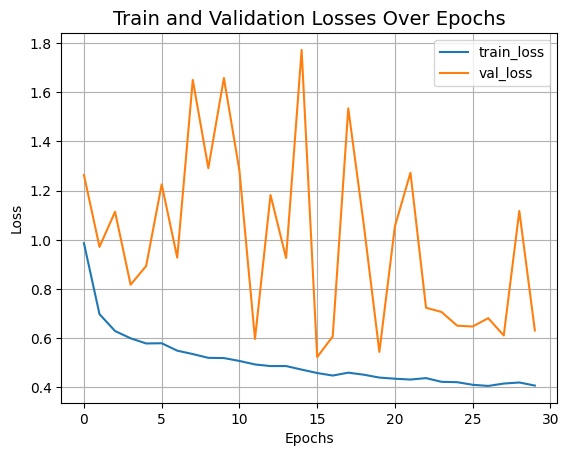

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()



---



# MobileNetV2

In [ ]:
# Create the base model from the pre-trained model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
#This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
#Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation=('softmax'))
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=input_shape)
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 350s 2s/step - loss: 0.8153 - accuracy: 0.7630 - precision: 0.8275 - recall: 0.6843 - f1_score: 0.7384 - val_loss: 0.6928 - val_accuracy: 0.8406 - val_precision: 0.8732 - val_recall: 0.7879 - val_f1_score: 0.8111
Epoch 2/30
179/179 [==============================] - 4s 22ms/step - loss: 0.6206 - accuracy: 0.8720 - precision: 0.9059 - recall: 0.8342 - f1_score: 0.8617 - val_loss: 0.6421 - val_accuracy: 0.8596 - val_precision: 0.8962 - val_recall: 0.8169 - val_f1_score: 0.8395
Epoch 3/30
179/179 [==============================] - 4s 23ms/step - loss: 0.5827 - accuracy: 0.8951 - precision: 0.9214 - recall: 0.8582 - f1_score: 0.8825 - val_loss: 0.6075 - val_accuracy: 0.8818 - val_precision: 0.9032 - val_recall: 0.8398 - val_f1_score: 0.8606
Epoch 4/30
179/179 [==============================] - 4s 22ms/step - loss: 0.5590 - accuracy: 0.9086 - precision: 0.9326 - recall: 0.8768 - f1_score: 0.8982 - val_loss: 0.5942 - val_accuracy: 0.8825 

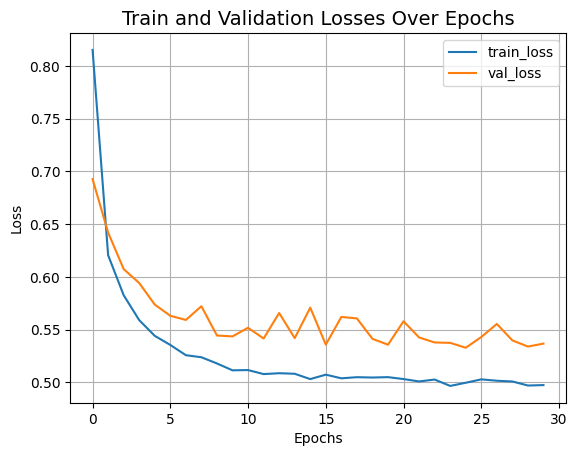

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()



---



# MobileNet

In [ ]:
# Create the base model from the pre-trained model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
base_model.trainable = False

In [ ]:
#This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
#Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation=('softmax'))
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=input_shape)
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 8s 28ms/step - loss: 0.8448 - accuracy: 0.7479 - precision_1: 0.8141 - recall_1: 0.6714 - f1_score: 0.7252 - val_loss: 0.6958 - val_accuracy: 0.8368 - val_precision_1: 0.8741 - val_recall_1: 0.7841 - val_f1_score: 0.8091
Epoch 2/30
179/179 [==============================] - 4s 22ms/step - loss: 0.6264 - accuracy: 0.8713 - precision_1: 0.9037 - recall_1: 0.8277 - f1_score: 0.8572 - val_loss: 0.6448 - val_accuracy: 0.8558 - val_precision_1: 0.8901 - val_recall_1: 0.8154 - val_f1_score: 0.8347
Epoch 3/30
179/179 [==============================] - 4s 22ms/step - loss: 0.5941 - accuracy: 0.8883 - precision_1: 0.9140 - recall_1: 0.8556 - f1_score: 0.8768 - val_loss: 0.6036 - val_accuracy: 0.8780 - val_precision_1: 0.9043 - val_recall_1: 0.8436 - val_f1_score: 0.8635
Epoch 4/30
179/179 [==============================] - 4s 23ms/step - loss: 0.5598 - accuracy: 0.9060 - precision_1: 0.9312 - recall_1: 0.8768 - f1_score: 0.8978 - val_loss: 0.

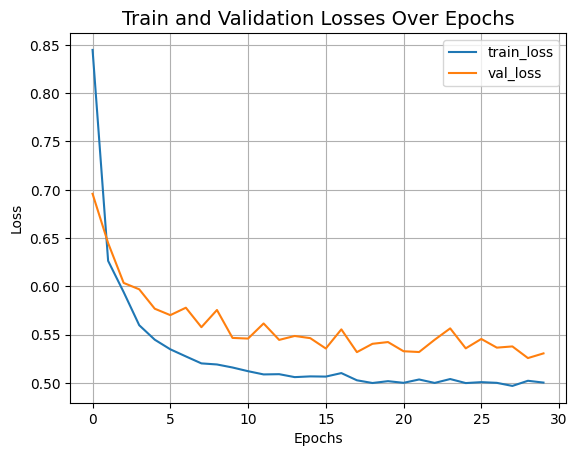

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()



---



# VGG16





In [ ]:
# Create the base model from the pre-trained model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation=('softmax'))) #This is the classification layer

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 19s 77ms/step - loss: 3.8289 - accuracy: 0.5485 - precision_2: 0.7101 - recall_2: 0.3027 - f1_score: 0.4007 - val_loss: 1.0784 - val_accuracy: 0.6575 - val_precision_2: 0.7200 - val_recall_2: 0.5492 - val_f1_score: 0.5492
Epoch 2/30
179/179 [==============================] - 11s 63ms/step - loss: 0.8082 - accuracy: 0.7822 - precision_2: 0.8499 - recall_2: 0.6761 - f1_score: 0.7418 - val_loss: 0.8691 - val_accuracy: 0.7605 - val_precision_2: 0.8302 - val_recall_2: 0.6751 - val_f1_score: 0.7057
Epoch 3/30
179/179 [==============================] - 11s 63ms/step - loss: 0.6928 - accuracy: 0.8395 - precision_2: 0.8826 - recall_2: 0.7817 - f1_score: 0.8214 - val_loss: 0.7708 - val_accuracy: 0.7864 - val_precision_2: 0.8338 - val_recall_2: 0.7193 - val_f1_score: 0.7463
Epoch 4/30
179/179 [==============================] - 11s 63ms/step - loss: 0.6477 - accuracy: 0.8647 - precision_2: 0.9005 - recall_2: 0.8125 - f1_score: 0.8470 - val_loss

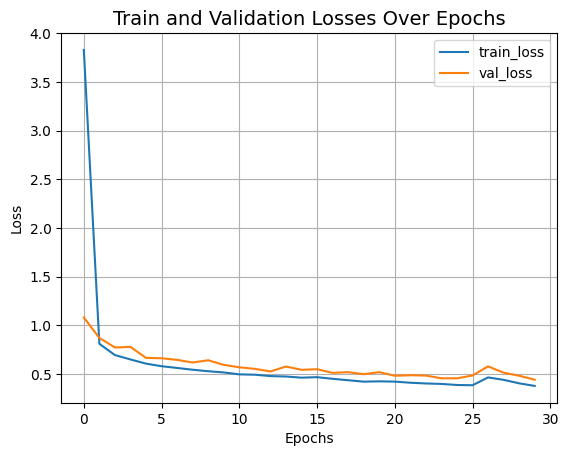

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()



---



# VGG19





In [ ]:
# Create the base model from the pre-trained model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation=('softmax'))) #This is the classification layer

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 15s 74ms/step - loss: 3.0938 - accuracy: 0.5394 - precision_3: 0.6722 - recall_3: 0.3482 - f1_score: 0.4315 - val_loss: 1.0270 - val_accuracy: 0.6354 - val_precision_3: 0.6987 - val_recall_3: 0.4653 - val_f1_score: 0.4746
Epoch 2/30
179/179 [==============================] - 13s 72ms/step - loss: 0.8265 - accuracy: 0.7460 - precision_3: 0.8124 - recall_3: 0.6436 - f1_score: 0.6964 - val_loss: 0.8429 - val_accuracy: 0.7353 - val_precision_3: 0.7782 - val_recall_3: 0.6743 - val_f1_score: 0.6833
Epoch 3/30
179/179 [==============================] - 13s 72ms/step - loss: 0.7201 - accuracy: 0.8183 - precision_3: 0.8641 - recall_3: 0.7456 - f1_score: 0.7871 - val_loss: 0.8034 - val_accuracy: 0.7765 - val_precision_3: 0.8214 - val_recall_3: 0.6979 - val_f1_score: 0.7277
Epoch 4/30
179/179 [==============================] - 13s 72ms/step - loss: 0.6575 - accuracy: 0.8552 - precision_3: 0.8937 - recall_3: 0.8081 - f1_score: 0.8407 - val_loss

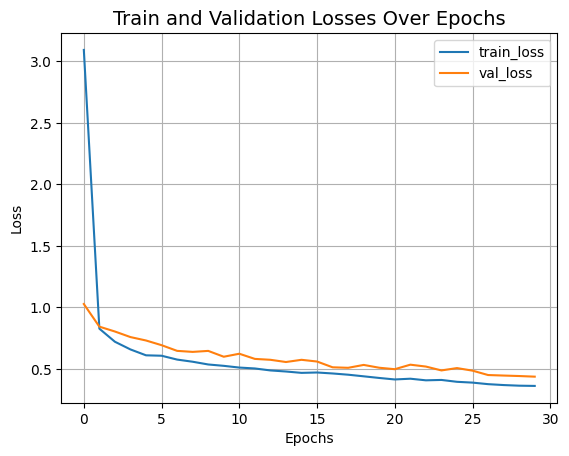

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


---
# ResNet50








In [ ]:
# Create the base model from the pre-trained model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation=('softmax'))) #This is the classification layer

94765736/94765736 [==============================] - 6s 0us/step


In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 24s 83ms/step - loss: 2.0939 - accuracy: 0.7997 - precision_4: 0.8517 - recall_4: 0.7216 - f1_score: 0.7762 - val_loss: 6324.1973 - val_accuracy: 0.3059 - val_precision_4: 0.3060 - val_recall_4: 0.3051 - val_f1_score: 0.1447
Epoch 2/30
179/179 [==============================] - 12s 66ms/step - loss: 0.7972 - accuracy: 0.8916 - precision_4: 0.9176 - recall_4: 0.8477 - f1_score: 0.8773 - val_loss: 0.7623 - val_accuracy: 0.7956 - val_precision_4: 0.8639 - val_recall_4: 0.7117 - val_f1_score: 0.7471
Epoch 3/30
179/179 [==============================] - 12s 66ms/step - loss: 0.5268 - accuracy: 0.9391 - precision_4: 0.9538 - recall_4: 0.9175 - f1_score: 0.9331 - val_loss: 0.5498 - val_accuracy: 0.9306 - val_precision_4: 0.9556 - val_recall_4: 0.8696 - val_f1_score: 0.9035
Epoch 4/30
179/179 [==============================] - 12s 66ms/step - loss: 0.4664 - accuracy: 0.9692 - precision_4: 0.9773 - recall_4: 0.9552 - f1_score: 0.9650 - val_l

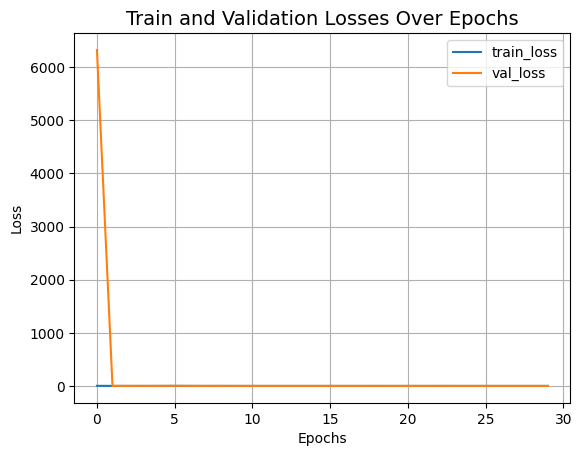

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


---
# ResNet152V2








In [ ]:
# Create the base model from the pre-trained model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation=('softmax'))) #This is the classification layer

234545216/234545216 [==============================] - 12s 0us/step


In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 47s 151ms/step - loss: 0.8294 - accuracy: 0.8340 - precision_5: 0.8754 - recall_5: 0.7859 - f1_score: 0.8223 - val_loss: 2.1729 - val_accuracy: 0.5660 - val_precision_5: 0.5894 - val_recall_5: 0.5408 - val_f1_score: 0.5179
Epoch 2/30
179/179 [==============================] - 23s 129ms/step - loss: 0.4917 - accuracy: 0.9443 - precision_5: 0.9589 - recall_5: 0.9263 - f1_score: 0.9405 - val_loss: 0.7227 - val_accuracy: 0.7918 - val_precision_5: 0.8315 - val_recall_5: 0.7605 - val_f1_score: 0.7841
Epoch 3/30
179/179 [==============================] - 23s 129ms/step - loss: 0.4224 - accuracy: 0.9730 - precision_5: 0.9791 - recall_5: 0.9655 - f1_score: 0.9717 - val_loss: 0.5205 - val_accuracy: 0.9428 - val_precision_5: 0.9565 - val_recall_5: 0.9214 - val_f1_score: 0.9348
Epoch 4/30
179/179 [==============================] - 23s 129ms/step - loss: 0.4176 - accuracy: 0.9771 - precision_5: 0.9816 - recall_5: 0.9692 - f1_score: 0.9744 - val_

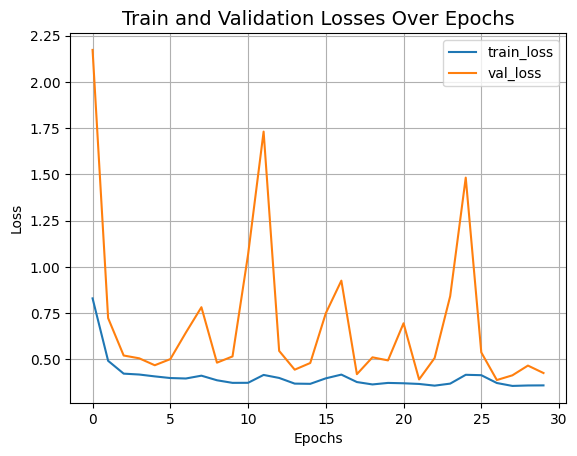

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()



---

# ⏰ Flush memory varibales before using the next transfomer

In [ ]:
del history
del model
del base_model
del optimizer